# Project 4: Road Finding

by Alex, Lorn, and Ted

## Hypothesis

It is possible to extract road networks from satellite imagery with enough clarity to distinguish them from non-road features.

## Data

Images and rasterized road segments within them in tiles over the state of Massechusetts at 1m resolution. A 0.5m DEM of Massechusetts. A global building footprint dataset from Microsoft. 

### Initial Visuals


In [15]:
from pathlib import Path
from itertools import islice

ROADS_DIR = Path("data/roads/")

for road_dir in ROADS_DIR.iterdir():
    if road_dir.is_dir():
        n = sum(1 for f in road_dir.iterdir() if f.is_file())
        print(road_dir.name, n)

train 1108
train_labels 1108
val 14
test_labels 49
test 49
val_labels 14


In [16]:
print("Image Files")
for item in islice(Path(ROADS_DIR / "train").iterdir(), 10):
    print(item.name)
print("\nLabel Files")
for item in islice(Path(ROADS_DIR / "train_labels").iterdir(), 10):
    print(item.name)

Image Files
17128945_15.tiff
26429275_15.tiff
22228930_15.tiff
20128900_15.tiff
22529395_15.tiff
20578900_15.tiff
24929230_15.tiff
11278945_15.tiff
27028705_15.tiff
24028810_15.tiff

Label Files
24478810_15.tif
11128855_15.tif
22679080_15.tif
11278660_15.tif
17128930_15.tif
24778825_15.tif
17578780_15.tif
15628855_15.tif
10528780_15.tif
17428945_15.tif


/home/lorn/Code/road-finding/.venv/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


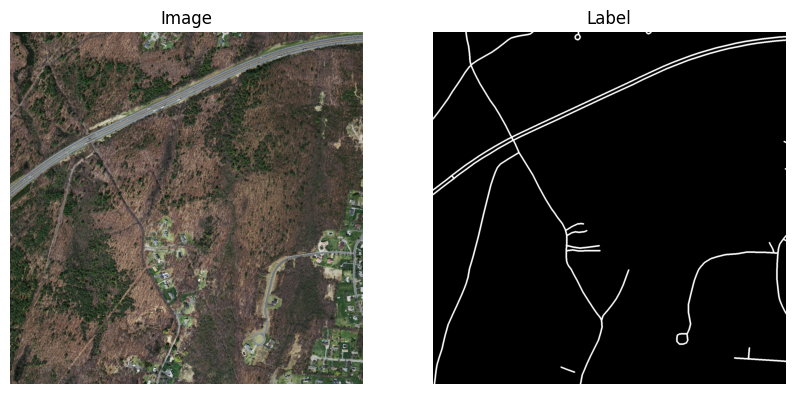

In [17]:
import rasterio
import matplotlib.pyplot as plt

img   = rasterio.open(ROADS_DIR/"test"/"10378780_15.tiff").read()
label = rasterio.open(ROADS_DIR/"test_labels"/"10378780_15.tif").read(1)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(img.transpose(1,2,0))
plt.title("Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(label, cmap="gray")
plt.title("Label")
plt.axis("off")

plt.show()

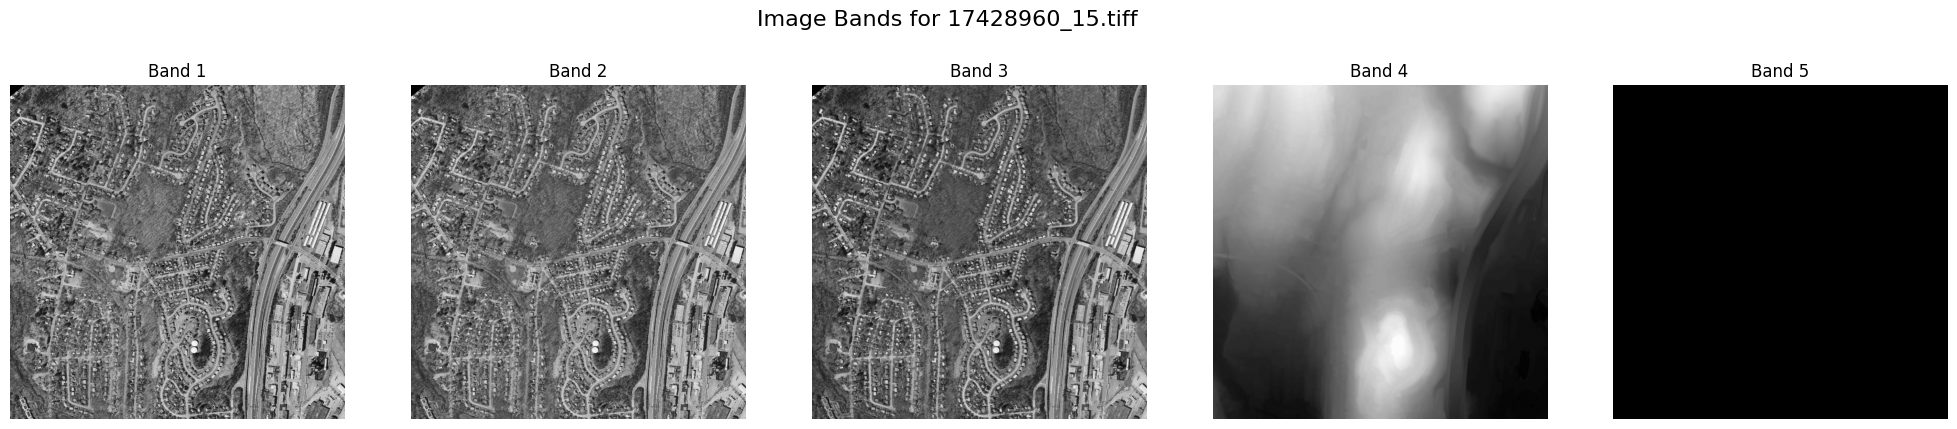

In [26]:
path = ROADS_DIR/"test"/"10378780_15.tiff"
path = Path("data/roads_buildings/train/17428960_15.tiff")
with rasterio.open(path) as src:
    img = src.read()   # shape: (bands, H, W)
    transform = src.transform
    width = src.width
    height = src.height

    # Pixel center indices
    cx = width  / 2
    cy = height / 2

    # Convert pixel center → map coordinates
    center_x, center_y = transform * (cx, cy)

bands, H, W = img.shape

plt.figure(figsize=(5 * bands, 5))
plt.suptitle(f"Image Bands for {path.name}", fontsize=16)
for i in range(bands):
    plt.subplot(1, bands, i+1)
    plt.imshow(img[i], cmap="gray")
    plt.title(f"Band {i+1}")
    plt.axis("off")

plt.show()

In [19]:
import geopandas as gpd
from shapely.geometry import box
import folium

DATA_DIR = Path("data/roads")  

records = []

for tif in DATA_DIR.rglob("*.tiff"):
    with rasterio.open(tif) as src:
        if not src.crs:
            continue
        
        left, bottom, right, top = src.bounds
        geom = box(left, bottom, right, top)

        records.append({
            "path": str(tif),
            "geometry": geom
        })

gdf = gpd.GeoDataFrame(records, crs="EPSG:26986")  
gdf_ll = gdf.to_crs("EPSG:4326")


center = [42.25, -71.8]

m = folium.Map(location=center, zoom_start=9, tiles="cartodb positron")

for _, row in gdf_ll.iterrows():
    geojson = folium.GeoJson(row["geometry"])
    geojson.add_to(m)

m

In [20]:
from pathlib import Path
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np

ROADS_DIR = Path("data/roads")
DEM_PATH = Path("data/dem/Lidar_Elevation_2013to2021.jp2")

OUT_ROOT = Path("data/roads_dem")
OUT_ROOT.mkdir(exist_ok=True)

splits = ["train", "val", "test"]

with rasterio.open(DEM_PATH) as dem_src:
    dem_crs = dem_src.crs
    dem_transform = dem_src.transform

for split in splits:
    in_dir = ROADS_DIR / split
    out_dir = OUT_ROOT / split
    out_dir.mkdir(parents=True, exist_ok=True)

    for tif in sorted(in_dir.glob("*.tif")) + sorted(in_dir.glob("*.tiff")):
        with rasterio.open(tif) as src:
            rgb = src.read()                  # (3, H, W)
            transform = src.transform
            crs = src.crs
            height, width = src.height, src.width
            profile = src.profile

        # Allocate DEM array matching the RGB tile size
        dem_tile = np.zeros((height, width), dtype=np.float32)

        with rasterio.open(DEM_PATH) as dem_src:
            reproject(
                source=rasterio.band(dem_src, 1),
                destination=dem_tile,
                src_transform=dem_src.transform,
                src_crs=dem_src.crs,
                dst_transform=transform,
                dst_crs=crs,
                resampling=Resampling.bilinear
            )

        # Stack RGB + DEM
        stacked = np.vstack([rgb.astype(np.float32),
                             dem_tile[np.newaxis, ...]])

        # Update profile for 4 bands
        profile.update(count=4, dtype="float32")

        out_path = out_dir / tif.name
        with rasterio.open(out_path, "w", **profile) as dst:
            dst.write(stacked)

        print("Wrote:", out_path)

Wrote: data/roads_dem/train/10078660_15.tiff


Wrote: data/roads_dem/train/10078675_15.tiff
Wrote: data/roads_dem/train/10078690_15.tiff
Wrote: data/roads_dem/train/10078705_15.tiff
Wrote: data/roads_dem/train/10078720_15.tiff
Wrote: data/roads_dem/train/10078735_15.tiff
Wrote: data/roads_dem/train/10078750_15.tiff
Wrote: data/roads_dem/train/10228660_15.tiff
Wrote: data/roads_dem/train/10228675_15.tiff
Wrote: data/roads_dem/train/10228705_15.tiff
Wrote: data/roads_dem/train/10228720_15.tiff
Wrote: data/roads_dem/train/10228735_15.tiff
Wrote: data/roads_dem/train/10228750_15.tiff
Wrote: data/roads_dem/train/10228765_15.tiff
Wrote: data/roads_dem/train/10228780_15.tiff
Wrote: data/roads_dem/train/10228795_15.tiff
Wrote: data/roads_dem/train/10378660_15.tiff
Wrote: data/roads_dem/train/10378675_15.tiff
Wrote: data/roads_dem/train/10378690_15.tiff
Wrote: data/roads_dem/train/10378705_15.tiff
Wrote: data/roads_dem/train/10378720_15.tiff
Wrote: data/roads_dem/train/10378735_15.tiff
Wrote: data/roads_dem/train/10378750_15.tiff
Wrote: dat

KeyboardInterrupt: 

In [ ]:
%reset -f

from pystac_client import Client
import planetary_computer as pc

catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=pc.sign_inplace
)

buildings_collection = catalog.get_collection("ms-buildings")

In [ ]:
import geopandas as gpd
from shapely.geometry import box
import pyproj
from shapely.ops import transform as shapely_transform
import pandas as pd

def fetch_buildings_for_tile(bounds_26986):
    """
    bounds_26986 = (minx, miny, maxx, maxy)
    Returns: GeoDataFrame of building polygons in EPSG:26986
    """

    # Convert tile bounds (26986) → WGS84
    proj_26986_to_4326 = pyproj.Transformer.from_crs(26986, 4326, always_xy=True).transform
    polygon_4326 = shapely_transform(proj_26986_to_4326, box(*bounds_26986))

    # ✔ Correct: use catalog.search(), NOT collection.search()
    search = catalog.search(
        collections=["ms-buildings"],
        intersects=polygon_4326,
        query={"msbuildings:processing-date": {"gte": "2023-04-25"}},
    )

    items = list(search.items())
    if not items:
        return gpd.GeoDataFrame(geometry=[], crs="EPSG:26986")

    gdfs = []
    for item in items:
        asset_href = pc.sign(item.assets["data"].href)
        gdf = gpd.read_parquet(asset_href)
        gdfs.append(gdf)

    # Combine, convert CRS
    buildings = gpd.GeoDataFrame(pd.concat(gdfs), crs="EPSG:4326")
    buildings = buildings.to_crs(26986)

    return buildings

from rasterio.features import rasterize

def rasterize_buildings(polygons_gdf, height, width, transform):
    shapes = [(geom, 1) for geom in polygons_gdf.geometry if geom is not None]
    mask = rasterize(
        shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype="uint8"
    )
    return mask

from tqdm import tqdm
from pathlib import Path
import rasterio
import numpy as np

ROADS_DIR  = Path("data/roads_dem")   # ← where your RGB+DEM tiles now live
OUT_DIR    = Path("data/roads_buildings")
OUT_DIR.mkdir(exist_ok=True)

splits = ["train", "val", "test"]

for split in splits:
    in_dir  = ROADS_DIR / split
    out_dir = OUT_DIR / split
    out_dir.mkdir(parents=True, exist_ok=True)

    tiles = sorted(in_dir.glob("*.tiff"))

    for tif in tqdm(tiles, desc=f"{split} tiles"):

        out_path = out_dir / tif.name
        if out_path.exists():
            continue

        with rasterio.open(tif) as src:
            data = src.read()    # (4, H, W): RGB + DEM
            tile_transform = src.transform
            bounds = src.bounds
            crs = src.crs
            height, width = src.height, src.width
            profile = src.profile

        # 1. Fetch building polygons for the tile bbox
        buildings = fetch_buildings_for_tile((bounds.left, bounds.bottom, bounds.right, bounds.top))

        # 2. Rasterize them into a building mask
        building_mask = rasterize_buildings(buildings, height, width, tile_transform).astype(np.uint8)

        # 3. Stack mask as new band
        stacked = np.vstack([data.astype(np.float32), 
                             building_mask[np.newaxis,...].astype(np.float32)])

        profile.update(count=5, dtype="float32")

        with rasterio.open(out_path, "w", **profile) as dst:
            dst.write(stacked)

train tiles:  42%|████▏     | 465/1108 [01:23<01:56,  5.54it/s] 


KeyboardInterrupt: 

In [ ]:
import rasterio
import geopandas as gpd
import pandas as pd
from shapely.geometry import box
from shapely.ops import transform as shapely_transform
import pyproj
import planetary_computer
import pystac_client
import deltalake
import mercantile
import contextily as ctx
import matplotlib.pyplot as plt

# ---------------------------
# 1. Pick one of your actual tiles
# ---------------------------

example_tile = "data/roads_buildings/train/17428960_15.tiff"

with rasterio.open(example_tile) as src:
    bounds_26986 = src.bounds
    crs_tile = src.crs

# Convert to WGS84
proj_to_wgs84 = pyproj.Transformer.from_crs(26986, 4326, always_xy=True).transform
bbox_wgs84_geom = shapely_transform(proj_to_wgs84, box(*bounds_26986))
bbox_wgs84 = box(*bbox_wgs84_geom.bounds)

# ---------------------------
# 2. Connect to Planetary Computer + Delta table
# ---------------------------

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
collection = catalog.get_collection("ms-buildings")
asset = collection.assets["delta"]

storage_options = {
    "account_name": asset.extra_fields["table:storage_options"]["account_name"],
    "sas_token": asset.extra_fields["table:storage_options"]["credential"],
}

table = deltalake.DeltaTable(asset.href, storage_options=storage_options)

# ---------------------------
# 3. Determine quadkeys at zoom level 9
# ---------------------------

quadkeys = [
    int(mercantile.quadkey(tile))
    for tile in mercantile.tiles(*bbox_wgs84.bounds, zooms=9)
]

# ---------------------------
# 4. Load parquet files for U.S. footprints matching quadkeys
# ---------------------------

uris = table.file_uris([
    ("RegionName", "=", "UnitedStates"),
    ("quadkey", "in", quadkeys),
])

df = pd.concat([
    gpd.read_parquet(uri, storage_options=storage_options)
    for uri in uris
])

# ---------------------------
# 5. Clip buildings to the tile bounding box
# ---------------------------

buildings_4326 = df.to_crs(4326).clip(bbox_wgs84)
buildings_26986 = buildings_4326.to_crs(26986)

# ---------------------------
# 6. Plot buildings on basemap
# ---------------------------

fig, ax = plt.subplots(figsize=(9, 9))
buildings_4326.plot(ax=ax, color="red", alpha=0.6, linewidth=0)

ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, zoom=17)
ax.set_title("Building Footprints for Tile {}".format(example_tile))
ax.set_axis_off()

plt.show()

RasterioIOError: data/roads/train/10228690_15.tiff: No such file or directory